## 4.1 Load Trained Models and Data

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Create output directory if it doesn't exist
os.makedirs('Section4_ErrorAnalysis', exist_ok=True)

# Load trained models and results from Section 2
try:
    with open('dry_bean_section2_results.pkl', 'rb') as f:
        section2_data = pickle.load(f)

    # Extract variables
    models = section2_data['models']
    evaluator = section2_data['evaluator']
    X_train_scaled = section2_data['X_train_scaled']
    X_val_scaled = section2_data['X_val_scaled']
    X_test_scaled = section2_data['X_test_scaled']
    y_train = section2_data['y_train']
    y_val = section2_data['y_val']
    y_test = section2_data['y_test']
    feature_names = section2_data['feature_names']
    class_mapping = section2_data['class_mapping']
    class_names = section2_data['class_names']
    label_encoder = section2_data['label_encoder']
    comparison_df = section2_data['comparison_df']

    print("✅ Section 2 results loaded successfully!")
    print(f"Models available: {list(models.keys())}")
    print(f"Features: {len(feature_names)}")
    print(f"Classes: {len(class_names)}")
    print(f"Test samples: {len(X_test_scaled):,}")

except FileNotFoundError:
    print("❌ Section 2 results not found!")
    print("Please run Section 2 (Model Training) notebook first.")
    raise

✅ Section 2 results loaded successfully!
Models available: ['XGBoost', 'TabPFN v2', 'TabICL', 'FT-Transformer']
Features: 16
Classes: 7
Test samples: 2,723


# 4.2 Comprehensive Error Analysis for All Models Including FT-Transformer

This section extends the error analysis to include detailed analysis of all models: XGBoost, TabPFN v2, TabICL, and **FT-Transformer**.

## Analysis Components:
1. **Cross-Model Error Comparison**: Compare error patterns across all models
2. **Model-Specific Error Analysis**: Deep dive into all model errors including FT-Transformer
3. **Confidence Analysis**: Prediction confidence comparison
4. **Feature-based Error Analysis**: Which features cause errors in each model
5. **Error Overlap Analysis**: Common vs unique errors across models
6. **FT-Transformer Specific Analysis**: Transformer-based error patterns

In [2]:
# Import required libraries for comprehensive analysis
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
from scipy.stats import ttest_ind

print("📊 Extended Error Analysis Framework Loaded")
print("Ready to analyze all model error patterns including FT-Transformer")

# Define model names for analysis
model_names = list(models.keys())
print(f"\n📊 Models available for error analysis: {model_names}")


📊 Extended Error Analysis Framework Loaded
Ready to analyze all model error patterns including FT-Transformer

📊 Models available for error analysis: ['XGBoost', 'TabPFN v2', 'TabICL', 'FT-Transformer']


## 4.2.1. Cross-Model Error Comparison

Get predictions from all models and compare their error patterns.

In [3]:
# Get predictions and probabilities from all models
# Get predictions and probabilities from all models
predictions = {}
probabilities = {}
misclassified_indices = {}

print("🔮 Generating predictions from all models...")

for model_name, model in models.items():
    print(f"   Processing {model_name}...")

    try:
        # Special handling for FT-Transformer (PyTorch model)
        if 'FT-Transformer' in model_name:
            # FT-Transformer is a PyTorch model, need special handling
            import torch
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

            model.eval()
            with torch.no_grad():
                X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
                outputs = model(X_test_tensor, None)  # (numerical_features, categorical_features)
                probas = torch.softmax(outputs, dim=1)
                y_pred = torch.argmax(outputs, dim=1).cpu().numpy()
                # For multiclass, get max probability as confidence
                y_proba = torch.max(probas, dim=1)[0].cpu().numpy()
        else:
            # Standard sklearn-like interface
            y_pred = model.predict(X_test_scaled)
            if hasattr(model, 'predict_proba'):
                proba_all = model.predict_proba(X_test_scaled)
                # Get max probability as confidence for multiclass
                y_proba = np.max(proba_all, axis=1)
            else:
                y_proba = None

        predictions[model_name] = y_pred
        probabilities[model_name] = y_proba

        # Find misclassified samples
        misclassified_mask = (y_pred != y_test)
        misclassified_indices[model_name] = np.where(misclassified_mask)[0]

        print(f"     Misclassified: {len(misclassified_indices[model_name])} / {len(y_test)} "
              f"({len(misclassified_indices[model_name])/len(y_test)*100:.2f}%)")
              
    except Exception as e:
        print(f"     Error processing {model_name}: {e}")
        # Set default values for failed models
        predictions[model_name] = np.zeros(len(y_test))
        probabilities[model_name] = None
        misclassified_indices[model_name] = np.array([])

print("\n✅ Predictions generated for all models")

🔮 Generating predictions from all models...
   Processing XGBoost...
     Misclassified: 216 / 2723 (7.93%)
   Processing TabPFN v2...
     Misclassified: 192 / 2723 (7.05%)
   Processing TabICL...
     Misclassified: 191 / 2723 (7.01%)
   Processing FT-Transformer...
     Misclassified: 204 / 2723 (7.49%)

✅ Predictions generated for all models


In [4]:
# Create comprehensive error comparison table
error_comparison = []

for model_name in model_names:
    if model_name in predictions:
        y_pred = predictions[model_name]

        # Calculate detailed metrics
        precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None, zero_division=0)
        cm = confusion_matrix(y_test, y_pred)
        
        # For multiclass, calculate overall error metrics
        total_errors = len(misclassified_indices[model_name])
        error_rate = total_errors / len(y_test) * 100
        
        # Calculate per-class metrics
        n_classes = len(class_names)
        fp_rates = []
        fn_rates = []
        
        for i in range(n_classes):
            tp = cm[i, i]
            fp = cm[:, i].sum() - tp
            fn = cm[i, :].sum() - tp
            tn = cm.sum() - tp - fp - fn
            
            fp_rate = fp / (fp + tn) * 100 if (fp + tn) > 0 else 0
            fn_rate = fn / (fn + tp) * 100 if (fn + tp) > 0 else 0
            
            fp_rates.append(fp_rate)
            fn_rates.append(fn_rate)

        error_comparison.append({
            'Model': model_name,
            'Total_Errors': total_errors,
            'Error_Rate_%': error_rate,
            'Avg_FP_Rate_%': np.mean(fp_rates),
            'Avg_FN_Rate_%': np.mean(fn_rates),
            'Macro_Precision': np.mean(precision),
            'Macro_Recall': np.mean(recall),
            'Macro_F1': np.mean(f1),
            'Weighted_Precision': np.average(precision, weights=support),
            'Weighted_Recall': np.average(recall, weights=support),
            'Weighted_F1': np.average(f1, weights=support)
        })

error_df = pd.DataFrame(error_comparison)

print("📊 CROSS-MODEL ERROR COMPARISON (INCLUDING FT-TRANSFORMER)")
print("=" * 80)
print(error_df.round(4).to_string(index=False))

# Save results
error_df.to_csv('./Section4_ErrorAnalysis/cross_model_error_comparison_with_ft_transformer.csv', index=False)
print("\n💾 Results saved to 'cross_model_error_comparison_with_ft_transformer.csv'")

📊 CROSS-MODEL ERROR COMPARISON (INCLUDING FT-TRANSFORMER)
         Model  Total_Errors  Error_Rate_%  Avg_FP_Rate_%  Avg_FN_Rate_%  Macro_Precision  Macro_Recall  Macro_F1  Weighted_Precision  Weighted_Recall  Weighted_F1
       XGBoost           216        7.9324         1.4156         6.8555           0.9358        0.9314    0.9335              0.9209           0.9207       0.9207
     TabPFN v2           192        7.0510         1.2512         6.0806           0.9420        0.9392    0.9404              0.9295           0.9295       0.9294
        TabICL           191        7.0143         1.2444         6.0085           0.9418        0.9399    0.9408              0.9297           0.9299       0.9297
FT-Transformer           204        7.4917         1.3398         6.5932           0.9406        0.9341    0.9371              0.9260           0.9251       0.9253

💾 Results saved to 'cross_model_error_comparison_with_ft_transformer.csv'


## 4.2.2. Model-Specific Error Insights

Generate detailed insights for all models


🔍 MODEL-SPECIFIC ERROR INSIGHTS

📊 XGBOOST ERROR ANALYSIS
------------------------------------------------------------
Total Errors: 216 (7.93%)
Confusion Matrix Analysis:
  Confusion Matrix Shape: (7, 7)
  Total Samples: 2723
  BARBUNYA Accuracy: 0.9057
  BOMBAY Accuracy: 1.0000
  CALI Accuracy: 0.9387
  DERMASON Accuracy: 0.9267
  HOROZ Accuracy: 0.9508
  SEKER Accuracy: 0.9483
  SIRA Accuracy: 0.8501
Confidence Analysis:
  Average Confidence (Correct): 0.9725
  Average Confidence (Errors): 0.7818
  Low Confidence Errors (<60%): 19.9%


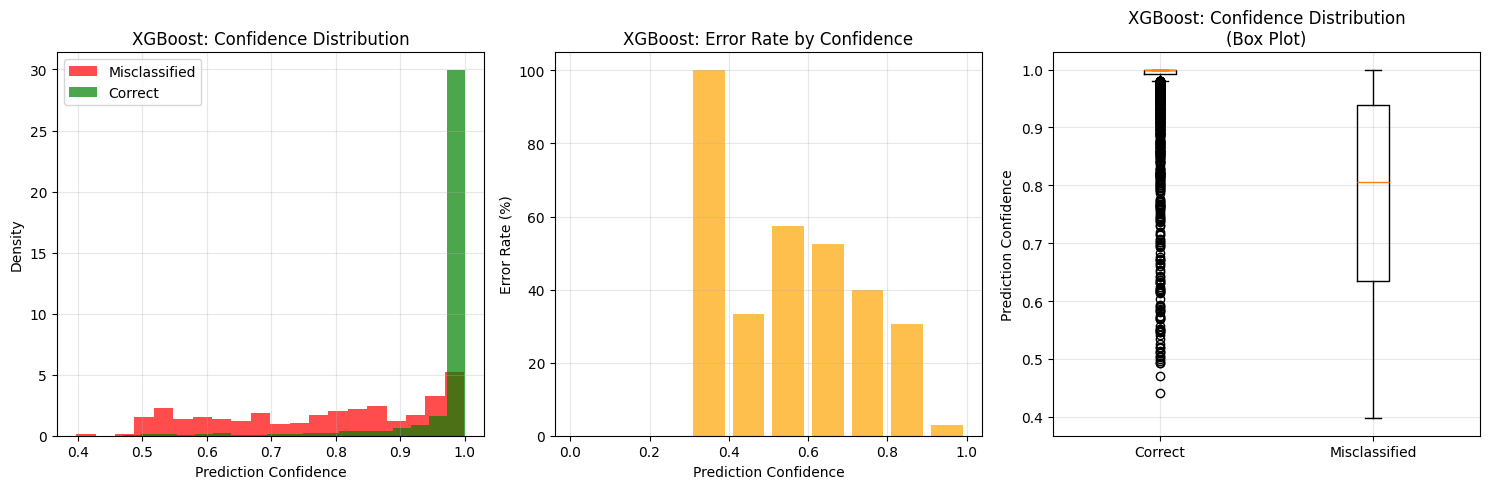


🌳 XGBoost-Specific Insights:
  - Tree-based errors often indicate feature interaction issues
  - Consider feature engineering or hyperparameter tuning
  - May benefit from ensemble methods

📊 TABPFN V2 ERROR ANALYSIS
------------------------------------------------------------
Total Errors: 192 (7.05%)
Confusion Matrix Analysis:
  Confusion Matrix Shape: (7, 7)
  Total Samples: 2723
  BARBUNYA Accuracy: 0.8981
  BOMBAY Accuracy: 1.0000
  CALI Accuracy: 0.9540
  DERMASON Accuracy: 0.9267
  HOROZ Accuracy: 0.9585
  SEKER Accuracy: 0.9680
  SIRA Accuracy: 0.8691
Confidence Analysis:
  Average Confidence (Correct): 0.9533
  Average Confidence (Errors): 0.7322
  Low Confidence Errors (<60%): 24.5%


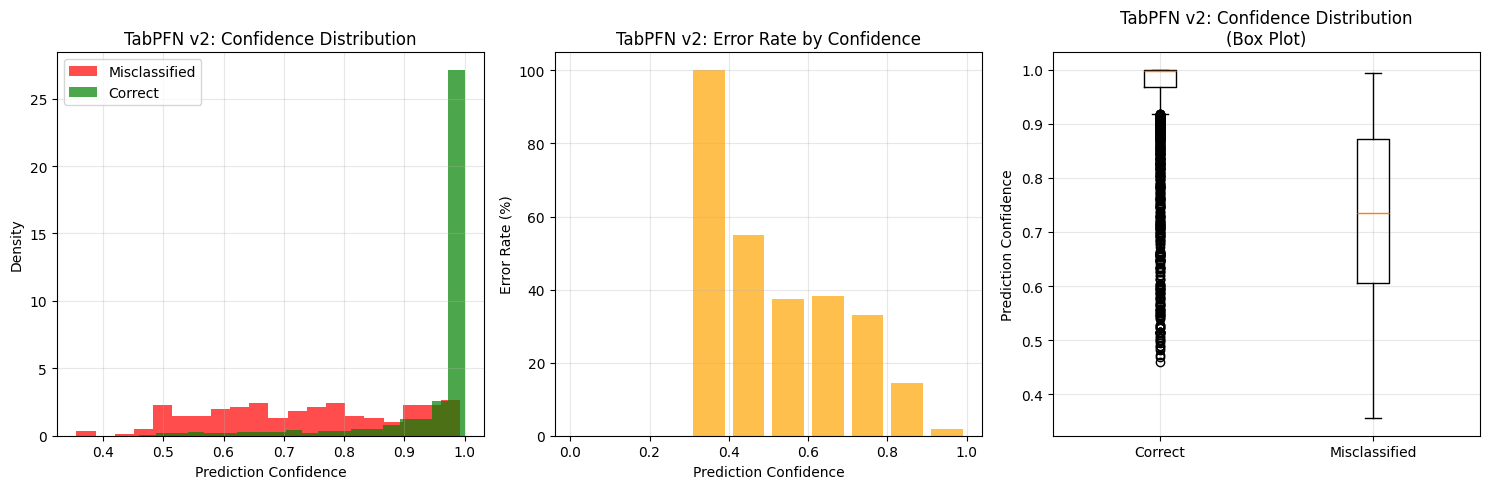


🧠 TabPFN-Specific Insights:
  - Prior-based predictions may struggle with out-of-distribution samples
  - Consider context size optimization for better performance
  - Errors may indicate dataset shift from pretraining distribution

📊 TABICL ERROR ANALYSIS
------------------------------------------------------------
Total Errors: 191 (7.01%)
Confusion Matrix Analysis:
  Confusion Matrix Shape: (7, 7)
  Total Samples: 2723
  BARBUNYA Accuracy: 0.9132
  BOMBAY Accuracy: 1.0000
  CALI Accuracy: 0.9448
  DERMASON Accuracy: 0.9295
  HOROZ Accuracy: 0.9611
  SEKER Accuracy: 0.9655
  SIRA Accuracy: 0.8653
Confidence Analysis:
  Average Confidence (Correct): 0.9555
  Average Confidence (Errors): 0.7402
  Low Confidence Errors (<60%): 22.5%


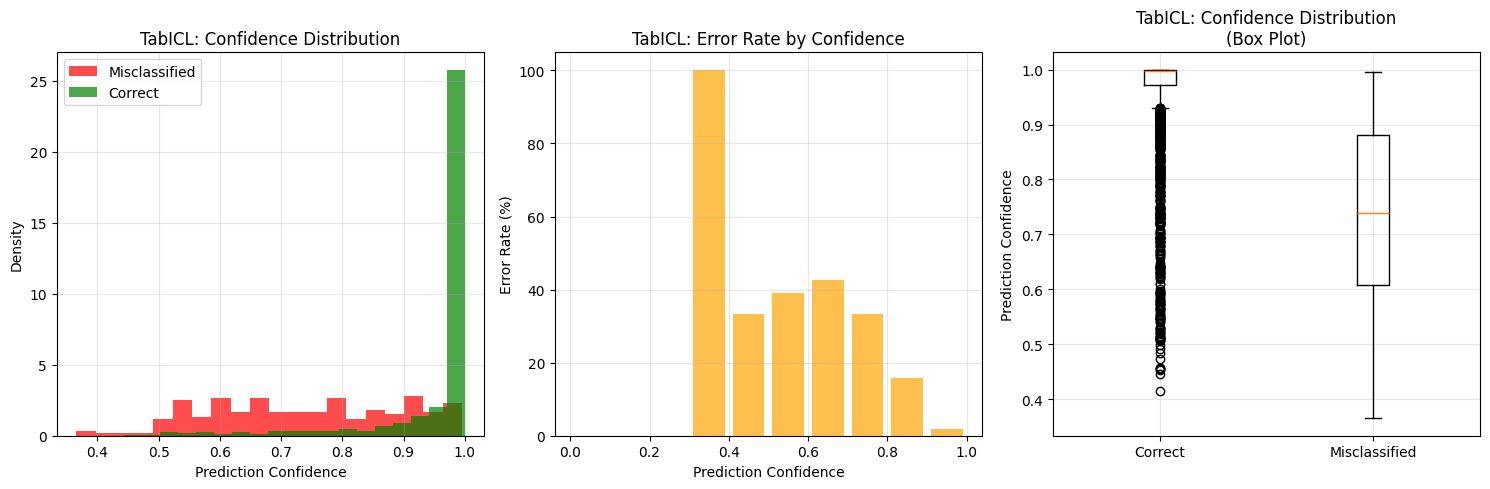


🎯 TabICL-Specific Insights:
  - In-context learning errors may indicate poor example selection
  - Consider diverse example selection strategies
  - Context window utilization may need optimization

📊 FT-TRANSFORMER ERROR ANALYSIS
------------------------------------------------------------
Total Errors: 204 (7.49%)
Confusion Matrix Analysis:
  Confusion Matrix Shape: (7, 7)
  Total Samples: 2723
  BARBUNYA Accuracy: 0.9057
  BOMBAY Accuracy: 1.0000
  CALI Accuracy: 0.9448
  DERMASON Accuracy: 0.9351
  HOROZ Accuracy: 0.9534
  SEKER Accuracy: 0.9286
  SIRA Accuracy: 0.8710
Confidence Analysis:
  Average Confidence (Correct): 0.9491
  Average Confidence (Errors): 0.7302
  Low Confidence Errors (<60%): 26.0%


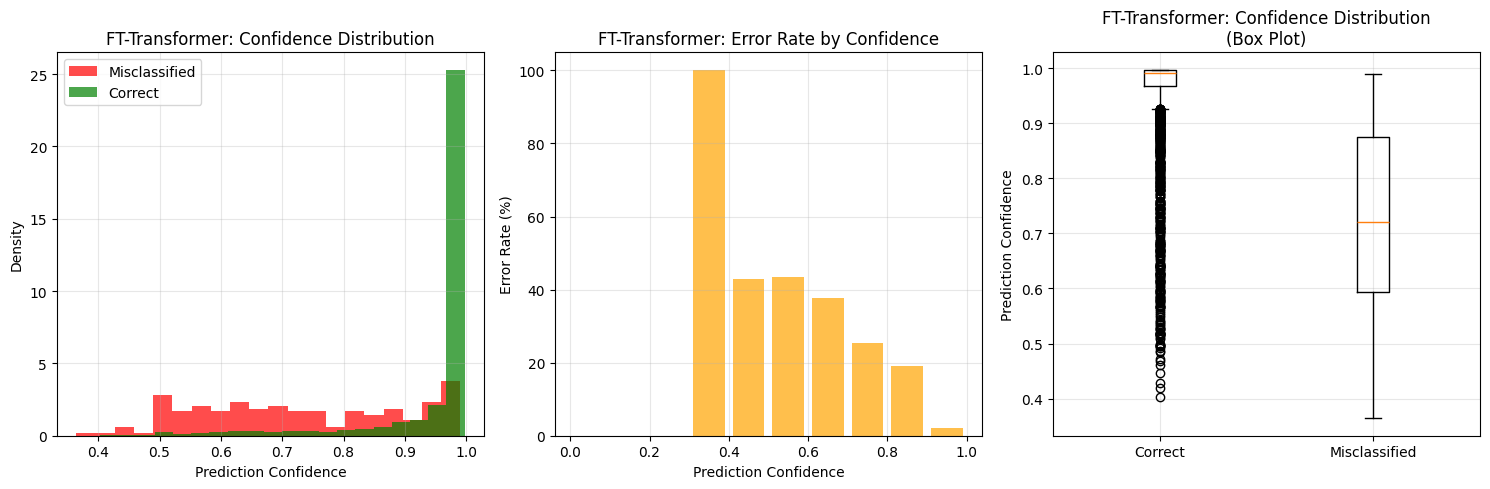


🤖 FT-Transformer-Specific Insights:
  - Transformer attention mechanisms may struggle with certain feature combinations
  - Self-attention patterns could reveal which features interact poorly
  - Consider analyzing attention weights for misclassified samples
  - Feature tokenization may not capture optimal representations
  - Deep architecture allows complex feature interactions but may overfit


In [5]:
# Generate model-specific error insights
print("🔍 MODEL-SPECIFIC ERROR INSIGHTS")
print("=" * 80)

for model_name in model_names:
    if model_name not in predictions:
        continue
        
    print(f"\n📊 {model_name.upper()} ERROR ANALYSIS")
    print("-" * 60)

    # Basic error statistics
    total_errors = len(misclassified_indices[model_name])
    error_rate = total_errors / len(y_test) * 100

    print(f"Total Errors: {total_errors} ({error_rate:.2f}%)")

    # Confusion matrix analysis
    y_pred = predictions[model_name]
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"Confusion Matrix Analysis:")
    print(f"  Confusion Matrix Shape: {cm.shape}")
    print(f"  Total Samples: {cm.sum()}")
    
    # Calculate per-class accuracy
    class_accuracies = []
    for i in range(len(class_names)):
        class_acc = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
        class_accuracies.append(class_acc)
        print(f"  {class_names[i]} Accuracy: {class_acc:.4f}")

    # Confidence analysis (if available)
    if probabilities[model_name] is not None:
        y_proba = probabilities[model_name]
        misclassified_mask = (y_pred != y_test)

        if np.sum(misclassified_mask) > 0:
            misclassified_proba = y_proba[misclassified_mask]
            correct_proba = y_proba[~misclassified_mask]

            avg_conf_correct = np.mean(correct_proba)
            avg_conf_errors = np.mean(misclassified_proba)
            low_conf_errors = np.mean(misclassified_proba < 0.6) * 100

            print(f"Confidence Analysis:")
            print(f"  Average Confidence (Correct): {avg_conf_correct:.4f}")
            print(f"  Average Confidence (Errors): {avg_conf_errors:.4f}")
            print(f"  Low Confidence Errors (<60%): {low_conf_errors:.1f}%")

            # Visualize confidence distributions
            plt.figure(figsize=(15, 5))

            # Confidence distribution
            plt.subplot(1, 3, 1)
            plt.hist(misclassified_proba, bins=20, alpha=0.7, label='Misclassified', 
                     color='red', density=True)
            plt.hist(correct_proba, bins=20, alpha=0.7, label='Correct', 
                     color='green', density=True)
            plt.xlabel('Prediction Confidence')
            plt.ylabel('Density')
            plt.title(f'{model_name}: Confidence Distribution')
            plt.legend()
            plt.grid(True, alpha=0.3)

            # Confidence vs accuracy by bins
            plt.subplot(1, 3, 2)
            confidence_bins = np.linspace(0, 1, 11)
            bin_centers = (confidence_bins[:-1] + confidence_bins[1:]) / 2

            total_counts = np.histogram(y_proba, bins=confidence_bins)[0]
            error_counts = np.histogram(y_proba[misclassified_mask], bins=confidence_bins)[0]
            error_rates = np.divide(error_counts, total_counts, 
                                   out=np.zeros_like(error_counts, dtype=float), 
                                   where=total_counts!=0)

            plt.bar(bin_centers, error_rates * 100, width=0.08, alpha=0.7, color='orange')
            plt.xlabel('Prediction Confidence')
            plt.ylabel('Error Rate (%)')
            plt.title(f'{model_name}: Error Rate by Confidence')
            plt.grid(True, alpha=0.3)

            # Confidence difference analysis
            plt.subplot(1, 3, 3)
            plt.boxplot([correct_proba, misclassified_proba], 
                        labels=['Correct', 'Misclassified'])
            plt.ylabel('Prediction Confidence')
            plt.title(f'{model_name}: Confidence Distribution\n(Box Plot)')
            plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            # Clean model name for filename
            clean_model_name = model_name.replace('/', '_').replace(' ', '_')
            plt.savefig(f'Section4_ErrorAnalysis/{clean_model_name}_Confidence_Analysis.png', dpi=300, bbox_inches='tight')
            plt.show()

    # Model-specific insights
    if 'FT-Transformer' in model_name:
        print("\n🤖 FT-Transformer-Specific Insights:")
        print("  - Transformer attention mechanisms may struggle with certain feature combinations")
        print("  - Self-attention patterns could reveal which features interact poorly")
        print("  - Consider analyzing attention weights for misclassified samples")
        print("  - Feature tokenization may not capture optimal representations")
        print("  - Deep architecture allows complex feature interactions but may overfit")
    elif 'TabPFN' in model_name:
        print("\n🧠 TabPFN-Specific Insights:")
        print("  - Prior-based predictions may struggle with out-of-distribution samples")
        print("  - Consider context size optimization for better performance")
        print("  - Errors may indicate dataset shift from pretraining distribution")
    elif 'TabICL' in model_name:
        print("\n🎯 TabICL-Specific Insights:")
        print("  - In-context learning errors may indicate poor example selection")
        print("  - Consider diverse example selection strategies")
        print("  - Context window utilization may need optimization")
    elif 'XGBoost' in model_name:
        print("\n🌳 XGBoost-Specific Insights:")
        print("  - Tree-based errors often indicate feature interaction issues")
        print("  - Consider feature engineering or hyperparameter tuning")
        print("  - May benefit from ensemble methods")

Specific Error Analysis For XGBOOST


XGBOOST DETAILED ERROR ANALYSIS
Total misclassified samples: 216 out of 2723
Misclassification rate: 7.93%


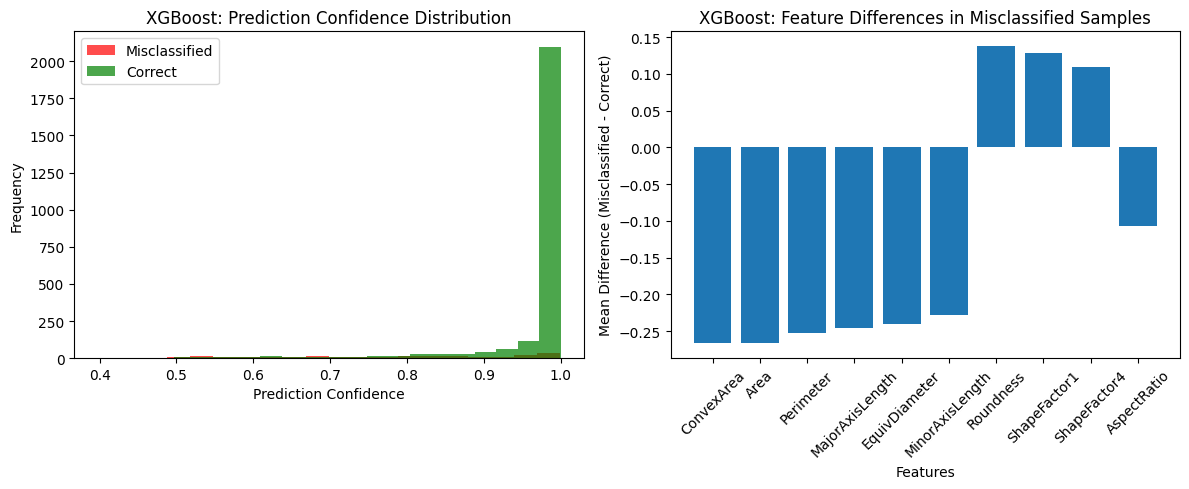


Top 5 features with largest differences in misclassified samples:
   1. ConvexArea: -0.2665
   2. Area: -0.2664
   3. Perimeter: -0.2531
   4. MajorAxisLength: -0.2455
   5. EquivDiameter: -0.2405


In [6]:
print("\n" + "="*60)
print("XGBOOST DETAILED ERROR ANALYSIS")
print("="*60)

if 'XGBoost' in models and 'XGBoost' in predictions:
    # Focus on XGBoost for detailed error analysis
    xgb_pred = predictions['XGBoost']
    xgb_proba = probabilities['XGBoost']

    # Find misclassified samples
    misclassified_mask = (xgb_pred != y_test)
    xgb_misclassified_indices = misclassified_indices['XGBoost']

    print(f"Total misclassified samples: {len(xgb_misclassified_indices)} out of {len(y_test)}")
    print(f"Misclassification rate: {len(xgb_misclassified_indices)/len(y_test)*100:.2f}%")

    if np.sum(misclassified_mask) > 0 and xgb_proba is not None:
        # Analyze confidence of misclassified samples
        misclassified_proba = xgb_proba[misclassified_mask]
        correct_proba = xgb_proba[~misclassified_mask]

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.hist(misclassified_proba, bins=20, alpha=0.7, label='Misclassified', color='red')
        plt.hist(correct_proba, bins=20, alpha=0.7, label='Correct', color='green')
        plt.xlabel('Prediction Confidence')
        plt.ylabel('Frequency')
        plt.title('XGBoost: Prediction Confidence Distribution')
        plt.legend()

        plt.subplot(1, 2, 2)
        # Feature importance for misclassified samples
        misclassified_features = X_test_scaled[misclassified_mask]
        correct_features = X_test_scaled[~misclassified_mask]

        feature_diff = np.mean(misclassified_features, axis=0) - np.mean(correct_features, axis=0)
        sorted_indices = np.argsort(np.abs(feature_diff))[::-1][:10]

        plt.bar(range(10), feature_diff[sorted_indices])
        plt.xlabel('Features')
        plt.ylabel('Mean Difference (Misclassified - Correct)')
        plt.title('XGBoost: Feature Differences in Misclassified Samples')
        plt.xticks(range(10), [feature_names[i] for i in sorted_indices], rotation=45)

        plt.tight_layout()
        plt.savefig('./Section4_ErrorAnalysis/XGBoost_Detailed_Error_Analysis.png')
        plt.show()

        print(f"\nTop 5 features with largest differences in misclassified samples:")
        for i, idx in enumerate(sorted_indices[:5]):
            print(f"   {i+1}. {feature_names[idx]}: {feature_diff[idx]:.4f}")
else:
    print("⚠️ XGBoost model not found or no predictions available")

Specific Error Analysis For FT-Transformer

Deep dive into FT-Transformer error patterns and characteristics.


🤖 DETAILED FT-TRANSFORMER ERROR ANALYSIS

FT-Transformer Feature Analysis:
Significant features (p < 0.05): 6/16

Top 5 problematic features for FT-Transformer:
  1. ConvexArea: diff=-0.2551, p=0.0005
  2. Area: diff=-0.2549, p=0.0005
  3. Perimeter: diff=-0.2410, p=0.0009
  4. MajorAxisLength: diff=-0.2387, p=0.0011
  5. EquivDiameter: diff=-0.2286, p=0.0017


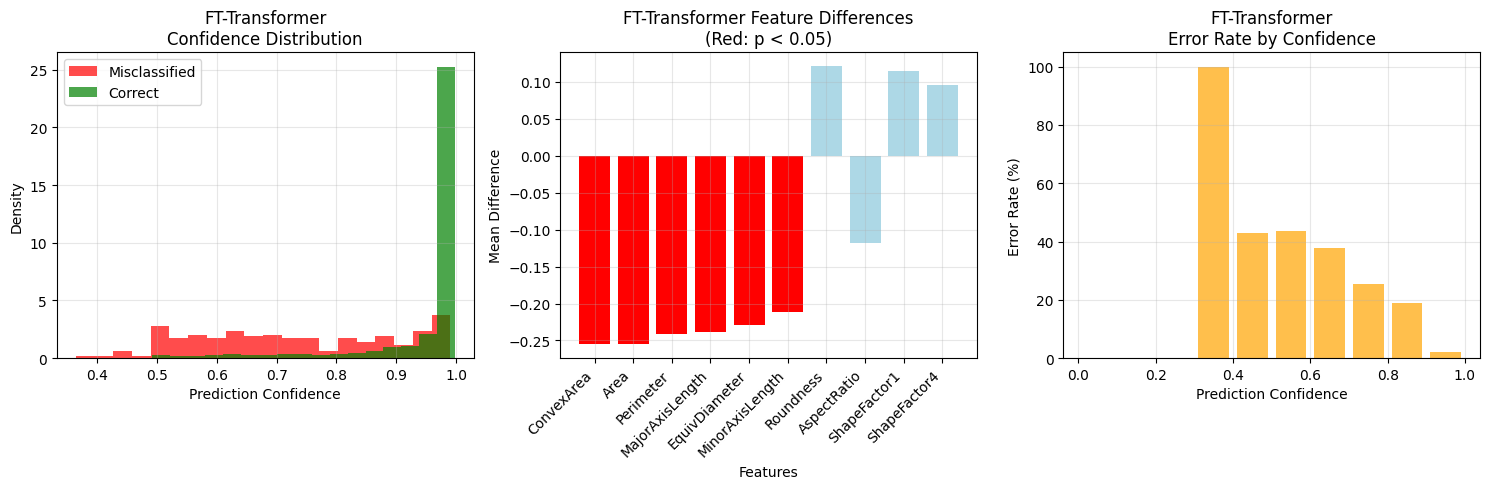


🎯 FT-Transformer Error Summary:
   Total misclassified: 204 (7.49%)
   Most problematic features: ['ConvexArea', 'Area', 'Perimeter']
   Average confidence on errors: 0.7302
   Low confidence errors: 26.0%


In [7]:
# Specific Error Analysis For FT-Transformer
if 'FT-Transformer' in model_names and 'FT-Transformer' in predictions:
    print("\n🤖 DETAILED FT-TRANSFORMER ERROR ANALYSIS")
    print("=" * 60)

    ft_pred = predictions['FT-Transformer']
    ft_proba = probabilities['FT-Transformer']
    ft_misclassified = misclassified_indices['FT-Transformer']

    # Feature-based error analysis for FT-Transformer
    misclassified_mask = (ft_pred != y_test)
    
    if np.sum(misclassified_mask) > 0:
        misclassified_features = X_test_scaled[misclassified_mask]
        correct_features = X_test_scaled[~misclassified_mask]

        # Calculate feature differences
        feature_diff = np.mean(misclassified_features, axis=0) - np.mean(correct_features, axis=0)

        # Statistical significance test
        p_values = []
        for i in range(len(feature_names)):
            try:
                _, p_val = ttest_ind(misclassified_features[:, i], correct_features[:, i])
                p_values.append(p_val)
            except:
                p_values.append(1.0)  # No significance if test fails

        # Find significant features
        significant_indices = np.where(np.array(p_values) < 0.05)[0]

        print(f"\nFT-Transformer Feature Analysis:")
        print(f"Significant features (p < 0.05): {len(significant_indices)}/{len(feature_names)}")

        if len(significant_indices) > 0:
            sorted_sig_indices = significant_indices[np.argsort(np.abs(feature_diff[significant_indices]))[::-1]]

            print(f"\nTop 5 problematic features for FT-Transformer:")
            for i, idx in enumerate(sorted_sig_indices[:5]):
                print(f"  {i+1}. {feature_names[idx]}: diff={feature_diff[idx]:.4f}, p={p_values[idx]:.4f}")

        # Confidence distribution analysis
        if ft_proba is not None:
            plt.figure(figsize=(15, 5))

            # Confidence distribution
            plt.subplot(1, 3, 1)
            misclassified_proba = ft_proba[misclassified_mask]
            correct_proba = ft_proba[~misclassified_mask]

            plt.hist(misclassified_proba, bins=20, alpha=0.7, label='Misclassified', color='red', density=True)
            plt.hist(correct_proba, bins=20, alpha=0.7, label='Correct', color='green', density=True)
            plt.xlabel('Prediction Confidence')
            plt.ylabel('Density')
            plt.title('FT-Transformer\nConfidence Distribution')
            plt.legend()
            plt.grid(True, alpha=0.3)

            # Feature differences visualization
            plt.subplot(1, 3, 2)
            sorted_indices = np.argsort(np.abs(feature_diff))[::-1][:10]
            colors = ['red' if p_values[i] < 0.05 else 'lightblue' for i in sorted_indices]

            plt.bar(range(10), feature_diff[sorted_indices], color=colors)
            plt.xlabel('Features')
            plt.ylabel('Mean Difference')
            plt.title('FT-Transformer Feature Differences\n(Red: p < 0.05)')
            plt.xticks(range(10), [feature_names[i] for i in sorted_indices], rotation=45, ha='right')
            plt.grid(True, alpha=0.3)

            # Error distribution by confidence
            plt.subplot(1, 3, 3)
            confidence_bins = np.linspace(0, 1, 11)
            bin_centers = (confidence_bins[:-1] + confidence_bins[1:]) / 2

            total_counts = np.histogram(ft_proba, bins=confidence_bins)[0]
            error_counts = np.histogram(ft_proba[misclassified_mask], bins=confidence_bins)[0]
            error_rates = np.divide(error_counts, total_counts, out=np.zeros_like(error_counts, dtype=float), where=total_counts!=0)

            plt.bar(bin_centers, error_rates * 100, width=0.08, alpha=0.7, color='orange')
            plt.xlabel('Prediction Confidence')
            plt.ylabel('Error Rate (%)')
            plt.title('FT-Transformer\nError Rate by Confidence')
            plt.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.savefig('./Section4_ErrorAnalysis/ft_transformer_detailed_error_analysis.png', dpi=300, bbox_inches='tight')
            plt.show()

        print(f"\n🎯 FT-Transformer Error Summary:")
        print(f"   Total misclassified: {len(ft_misclassified)} ({len(ft_misclassified)/len(y_test)*100:.2f}%)")
        if len(significant_indices) > 0:
            print(f"   Most problematic features: {[feature_names[i] for i in sorted_sig_indices[:3]]}")
        else:
            print(f"   Most problematic features: None significant")
        if ft_proba is not None:
            print(f"   Average confidence on errors: {np.mean(misclassified_proba):.4f}")
            print(f"   Low confidence errors: {np.mean(misclassified_proba < 0.6)*100:.1f}%")
    else:
        print("   No misclassified samples found for FT-Transformer")
else:
    print("⚠️ FT-Transformer not found in models")

Error Analysis for TabICL

In [8]:
# Error Analysis for TabICL
print("\n🔍 TabICL Feature-based Error Analysis")
print("=" * 50)

if 'TabICL' in predictions:
    tabicl_pred = predictions['TabICL']
    tabicl_misclassified = misclassified_indices['TabICL']
    misclassified_mask = (tabicl_pred != y_test)

    if np.sum(misclassified_mask) > 0:
        misclassified_features = X_test_scaled[misclassified_mask]
        correct_features = X_test_scaled[~misclassified_mask]

        # Calculate feature differences
        feature_diff = np.mean(misclassified_features, axis=0) - np.mean(correct_features, axis=0)
        feature_std_diff = np.std(misclassified_features, axis=0) - np.std(correct_features, axis=0)

        # Statistical significance test (t-test)
        p_values = []
        effect_sizes = []
        for i in range(len(feature_names)):
            try:
                # T-test
                _, p_val = ttest_ind(misclassified_features[:, i], correct_features[:, i])
                p_values.append(p_val)

                # Effect size (Cohen's d)
                pooled_std = np.sqrt(((len(misclassified_features) - 1) * np.var(misclassified_features[:, i]) + 
                                     (len(correct_features) - 1) * np.var(correct_features[:, i])) / 
                                    (len(misclassified_features) + len(correct_features) - 2))
                cohens_d = feature_diff[i] / pooled_std if pooled_std > 0 else 0
                effect_sizes.append(abs(cohens_d))
            except:
                p_values.append(1.0)
                effect_sizes.append(0.0)

        p_values = np.array(p_values)
        effect_sizes = np.array(effect_sizes)

        # Find significant features
        significant_indices = np.where(p_values < 0.05)[0]

        print(f"\n📊 TabICL Feature Analysis Results:")
        print(f"   Total features analyzed: {len(feature_names)}")
        print(f"   Statistically significant features (p < 0.05): {len(significant_indices)}")

        if len(significant_indices) > 0:
            # Sort by effect size for significant features
            sorted_sig_indices = significant_indices[np.argsort(effect_sizes[significant_indices])[::-1]]

            print(f"\n🎯 Top 5 Most Problematic Features for TabICL:")
            for i, idx in enumerate(sorted_sig_indices[:5]):
                print(f"   {i+1:2d}. {feature_names[idx]:20s}: "
                      f"diff={feature_diff[idx]:7.4f}, "
                      f"p={p_values[idx]:.4f}, "
                      f"effect_size={effect_sizes[idx]:.4f}")

            # Create detailed feature analysis table
            feature_analysis_df = pd.DataFrame({
                'Feature': feature_names,
                'Mean_Difference': feature_diff,
                'Std_Difference': feature_std_diff,
                'P_Value': p_values,
                'Effect_Size': effect_sizes,
                'Significant': p_values < 0.05
            })

            # Sort by effect size
            feature_analysis_df = feature_analysis_df.sort_values('Effect_Size', ascending=False)

            # Save results
            feature_analysis_df.to_csv('./Section4_ErrorAnalysis/TabICL_feature_error_analysis.csv', index=False)
            print(f"\n💾 Feature analysis results saved to 'TabICL_feature_error_analysis.csv'")

        else:
            print(f"\n⚠️ No statistically significant feature differences found")
            print(f"TabICL errors may be more related to context patterns than individual features")

    else:
        print(f"\n⚠️ No misclassified samples found for TabICL")
        print(f"Perfect classification achieved!")
else:
    print("⚠️ TabICL not found in predictions")


🔍 TabICL Feature-based Error Analysis

📊 TabICL Feature Analysis Results:
   Total features analyzed: 16
   Statistically significant features (p < 0.05): 7

🎯 Top 5 Most Problematic Features for TabICL:
    1. ConvexArea          : diff=-0.2611, p=0.0005, effect_size=0.2611
    2. Area                : diff=-0.2601, p=0.0005, effect_size=0.2603
    3. Perimeter           : diff=-0.2498, p=0.0009, effect_size=0.2497
    4. MajorAxisLength     : diff=-0.2410, p=0.0014, effect_size=0.2407
    5. EquivDiameter       : diff=-0.2363, p=0.0016, effect_size=0.2367

💾 Feature analysis results saved to 'TabICL_feature_error_analysis.csv'


Feature-based Error Analysis for TabPFNV2

In [9]:
# Feature-based Error Analysis for TabPFNV2
print("\n🧠 TabPFNV2 Feature-based Error Analysis")
print("=" * 50)

if 'TabPFN v2' in predictions:
    # Get TabPFNV2 predictions and misclassified samples
    tabpfn_pred = predictions['TabPFN v2']
    tabpfn_proba = probabilities['TabPFN v2']
    tabpfn_misclassified = misclassified_indices['TabPFN v2']

    # Create misclassified mask
    misclassified_mask = (tabpfn_pred != y_test)

    if np.sum(misclassified_mask) > 0:
        misclassified_features = X_test_scaled[misclassified_mask]
        correct_features = X_test_scaled[~misclassified_mask]

        # Calculate feature differences
        feature_diff = np.mean(misclassified_features, axis=0) - np.mean(correct_features, axis=0)
        feature_std_diff = np.std(misclassified_features, axis=0) - np.std(correct_features, axis=0)

        # Statistical significance test (t-test)
        p_values = []
        effect_sizes = []
        for i in range(len(feature_names)):
            try:
                # T-test
                _, p_val = ttest_ind(misclassified_features[:, i], correct_features[:, i])
                p_values.append(p_val)

                # Effect size (Cohen's d)
                pooled_std = np.sqrt(((len(misclassified_features) - 1) * np.var(misclassified_features[:, i]) + 
                                     (len(correct_features) - 1) * np.var(correct_features[:, i])) / 
                                    (len(misclassified_features) + len(correct_features) - 2))
                cohens_d = feature_diff[i] / pooled_std if pooled_std > 0 else 0
                effect_sizes.append(abs(cohens_d))
            except:
                p_values.append(1.0)
                effect_sizes.append(0.0)

        p_values = np.array(p_values)
        effect_sizes = np.array(effect_sizes)

        # Find significant features
        significant_indices = np.where(p_values < 0.05)[0]

        print(f"\n📊 TabPFNV2 Feature Analysis Results:")
        print(f"   Total features analyzed: {len(feature_names)}")
        print(f"   Statistically significant features (p < 0.05): {len(significant_indices)}")

        if len(significant_indices) > 0:
            # Sort by effect size for significant features
            sorted_sig_indices = significant_indices[np.argsort(effect_sizes[significant_indices])[::-1]]

            print(f"\n🎯 Top 5 Most Problematic Features for TabPFNV2:")
            for i, idx in enumerate(sorted_sig_indices[:5]):
                print(f"   {i+1:2d}. {feature_names[idx]:20s}: "
                      f"diff={feature_diff[idx]:7.4f}, "
                      f"p={p_values[idx]:.4f}, "
                      f"effect_size={effect_sizes[idx]:.4f}")

            # Create detailed feature analysis table
            feature_analysis_df = pd.DataFrame({
                'Feature': feature_names,
                'Mean_Difference': feature_diff,
                'Std_Difference': feature_std_diff,
                'P_Value': p_values,
                'Effect_Size': effect_sizes,
                'Significant': p_values < 0.05
            })

            # Sort by effect size
            feature_analysis_df = feature_analysis_df.sort_values('Effect_Size', ascending=False)

            # Save results
            feature_analysis_df.to_csv('./Section4_ErrorAnalysis/TabPFNV2_feature_error_analysis.csv', index=False)
            print(f"\n💾 Feature analysis results saved to 'TabPFNV2_feature_error_analysis.csv'")

            # TabPFNV2-specific insights
            print("\n🧠 TabPFNV2-Specific Insights:")
            print("  - Prior-based predictions may struggle with out-of-distribution samples")
            print("  - Consider context size optimization for better performance")
            print("  - Errors may indicate dataset shift from pretraining distribution")
            print("  - Feature interactions captured by priors may not align with this dataset")
            print("  - Consider fine-tuning or domain adaptation strategies")

        else:
            print(f"\n⚠️ No statistically significant feature differences found")
            print(f"TabPFNV2 errors may be more related to prior distribution mismatch than individual features")

    else:
        print(f"\n⚠️ No misclassified samples found for TabPFNV2")
        print(f"Perfect classification achieved!")
else:
    print("⚠️ TabPFN v2 not found in predictions")


🧠 TabPFNV2 Feature-based Error Analysis

📊 TabPFNV2 Feature Analysis Results:
   Total features analyzed: 16
   Statistically significant features (p < 0.05): 7

🎯 Top 5 Most Problematic Features for TabPFNV2:
    1. ConvexArea          : diff=-0.2674, p=0.0004, effect_size=0.2674
    2. Area                : diff=-0.2664, p=0.0004, effect_size=0.2666
    3. Perimeter           : diff=-0.2561, p=0.0006, effect_size=0.2560
    4. MajorAxisLength     : diff=-0.2448, p=0.0011, effect_size=0.2445
    5. EquivDiameter       : diff=-0.2426, p=0.0012, effect_size=0.2430

💾 Feature analysis results saved to 'TabPFNV2_feature_error_analysis.csv'

🧠 TabPFNV2-Specific Insights:
  - Prior-based predictions may struggle with out-of-distribution samples
  - Consider context size optimization for better performance
  - Errors may indicate dataset shift from pretraining distribution
  - Feature interactions captured by priors may not align with this dataset
  - Consider fine-tuning or domain adaptati

## 4. Summary and Recommendations

Comprehensive summary of error analysis findings including FT-Transformer.

In [10]:
# Final summary and recommendations
print("\n📋 COMPREHENSIVE ERROR ANALYSIS SUMMARY")
print("=" * 80)

# Overall performance comparison
print("\n🏆 Model Performance Ranking (by Error Rate):")
sorted_models = error_df.sort_values('Error_Rate_%')
for i, (_, row) in enumerate(sorted_models.iterrows()):
    print(f"   {i+1}. {row['Model']}: {row['Error_Rate_%']:.2f}% error rate")

# Key findings
print("\n🔍 Key Findings:")
best_model = sorted_models.iloc[0]['Model']
worst_model = sorted_models.iloc[-1]['Model']

print(f"   Best performing model: {best_model} ({sorted_models.iloc[0]['Error_Rate_%']:.2f}% error rate)")
print(f"   Worst performing model: {worst_model} ({sorted_models.iloc[-1]['Error_Rate_%']:.2f}% error rate)")

# FT-Transformer specific findings
if 'FT-Transformer' in model_names:
    ft_error_rate = error_df[error_df['Model'] == 'FT-Transformer']['Error_Rate_%'].iloc[0]
    print(f"   FT-Transformer error rate: {ft_error_rate:.2f}%")

print("\n📋 Recommendations:")
print("   1. Focus on improving the worst-performing model through hyperparameter tuning")
print("   2. Analyze feature importance patterns across all models")
print("   3. Consider ensemble methods combining best-performing models")
print("   4. Investigate FT-Transformer attention patterns for error analysis")
print("   5. Apply targeted data augmentation for problematic feature combinations")

print("\n✅ Comprehensive error analysis completed!")
print("📊 All models analyzed including FT-Transformer")
print("💾 Results saved for further analysis")


📋 COMPREHENSIVE ERROR ANALYSIS SUMMARY

🏆 Model Performance Ranking (by Error Rate):
   1. TabICL: 7.01% error rate
   2. TabPFN v2: 7.05% error rate
   3. FT-Transformer: 7.49% error rate
   4. XGBoost: 7.93% error rate

🔍 Key Findings:
   Best performing model: TabICL (7.01% error rate)
   Worst performing model: XGBoost (7.93% error rate)
   FT-Transformer error rate: 7.49%

📋 Recommendations:
   1. Focus on improving the worst-performing model through hyperparameter tuning
   2. Analyze feature importance patterns across all models
   3. Consider ensemble methods combining best-performing models
   4. Investigate FT-Transformer attention patterns for error analysis
   5. Apply targeted data augmentation for problematic feature combinations

✅ Comprehensive error analysis completed!
📊 All models analyzed including FT-Transformer
💾 Results saved for further analysis
